<a href="https://colab.research.google.com/github/Chu-Yichen/QM2-Group-19/blob/main/MAIN_Data_Collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Get Site IDs**

In [10]:
!pip install haversine
import pandas as pd
import numpy as np
import math
import haversine
import requests

monitors = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/aqs_monitors.zip', converters={'State Code': str, 'County Code': str, 'Site Number': str})
monitors['Site Id'] = monitors['State Code'] + '-' + monitors['County Code'] + '-' + monitors['Site Number']
# Creates a unique ID for each site
monitors = monitors[monitors['Parameter Code'].isin([81102, 88101, 44201, 42401, 42101, 42602])]
"""
Extracting monitors that contain our desired pollutants (PM10, PM2.5, Ozone, SO2, NO2, CO)
Ozone (O3 - ppm): 44201
PM2.5 (µg/m3): 88101
PM10 (µg/m3): 81102
CO (ppm): 42101
SO2 (ppb): 42401
NO2 (ppb): 42602
"""

monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
monitors['Last Sample Date'] = pd.to_datetime(monitors['Last Sample Date'], errors='coerce')

# Extract the 'year' part of the Last Sample Date column
monitors['Last Year'] = monitors['Last Sample Date'].dt.year
monitors['Fist Year'] = monitors['First Year of Data']


"""
Counties in the Atlanta region (with their FIPS codes): https://atlantaregional.org/about-arc/about-the-atlanta-region/

Cherokee: 057
Clayton: 063
Cobb: 067
DeKalb: 089
Douglas: 097
Fayette: 113
Forsyth: 117
Fulton: 121
Gwinnett: 135
Henry: 151
Rockdale: 247
"""

# Filter the monitors, only leave those with 6 pollutants data available from 1999 to 2024.
atl_counties = ['057','063','067','089','097','113','117','121','135','151','247']
monitors = monitors[(monitors['State Code'] == '13') & (monitors['County Code'].isin(atl_counties))]


site_locations = monitors[['Site Id', 'Latitude', 'Longitude']]
# Filter the dataframe by Site ID and co-ordinates
site_locations = site_locations.drop_duplicates()
site_locations = site_locations.dropna()
# Creates unique rows for each site and removes any sites that do not contain Latitudes and Longitudes
site_locations = site_locations.set_index('Site Id')

def get_site_distances_km(site_locations, lat, lng):
    site_distances = {}
    for site_id, site_row in site_locations.iterrows():
        site_distances[site_id] = haversine.haversine((lat, lng), (site_row['Latitude'], site_row['Longitude']))
    return site_distances
# A function that finds the distance between inputted co-ordinates and each site. This returns a dictionary of site number and distance.

distances = get_site_distances_km(site_locations, 33.6324, -84.4333)
# Co-ordinates for Hartsfield-Jackson Atlanta International Airport into our function.

nearby_site_ids = [site_id for site_id, distance in distances.items() if distance < 20]
# This retrieves all of the site IDs within a 20km radius from the airport.
all_site_ids = set(site_locations.index.tolist()) - set(nearby_site_ids)
# All eligible sites in Atlanta, excluding those within a 20km radius.

# Print the results
print("Monitors within 20 km of Atlanta Airport:")
print(set(nearby_site_ids))
nearby_site_ids_lsit = list(nearby_site_ids)
print(monitors[monitors['Site Id'].isin(nearby_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))

print("\nOther monitors within the specified counties and time range:")
print(set(all_site_ids))
all_site_ids_list = list(all_site_ids)
print(monitors[monitors['Site Id'].isin(all_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))

<ipython-input-10-3306687dec96>:8: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  monitors = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/aqs_monitors.zip', converters={'State Code': str, 'County Code': str, 'Site Number': str})


Monitors within 20 km of Atlanta Airport:
{'13-121-0055', '13-121-0031', '13-121-0001', '13-121-0039', '13-121-0002', '13-121-0003', '13-121-0048', '13-121-0036', '13-121-0034', '13-121-5001', '13-089-0002', '13-121-0056', '13-121-0043', '13-121-0035', '13-089-0003', '13-121-0038', '13-063-0091', '13-121-0051', '13-121-5002', '13-121-0047', '13-121-4001', '13-121-0041', '13-113-0001', '13-121-0050', '13-121-0053', '13-121-1001'}
                                         First Year of Data Last Sample Date
Parameter Code Parameter Name                                               
42101          Carbon monoxide                       1972.0       2024-10-31
42401          Sulfur dioxide                        1962.0       2024-10-31
42602          Nitrogen dioxide (NO2)                1972.0       2024-08-31
44201          Ozone                                 1972.0       2024-08-31
81102          PM10 Total 0-10um STP                 1986.0       2024-09-30
88101          PM2.5 - Local

<ipython-input-10-3306687dec96>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
<ipython-input-10-3306687dec96>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitors['Last Sample Date'] = pd.to_datetime(monitors['Last Sample Date'], errors='coerce')
<ipython-input-10-3306687dec96>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

**Get Pollutants data for 1999**

['13-097-0004', '13-067-0004', '13-057-0001', '13-097-0003', '13-247-0001', '13-121-0054', '13-097-0002', '13-089-3001', '13-135-0002', '13-121-0052', '13-121-0042', '13-151-0002', '13-121-0099', '13-089-2001', '13-121-0044', '13-067-0003', '13-121-0032', '13-089-1002', '13-063-0091', '13-089-0002', '13-089-0003', '13-113-0001', '13-121-0001', '13-121-0002', '13-121-0003', '13-121-0031', '13-121-0034', '13-121-0035', '13-121-0036', '13-121-0038', '13-121-0039', '13-121-0041', '13-121-0043', '13-121-0047', '13-121-0048', '13-121-0050', '13-121-0051', '13-121-0053', '13-121-0055', '13-121-0056', '13-121-1001', '13-121-4001', '13-121-5001', '13-121-5002']
Unique Site IDs for https://aqs.epa.gov/aqsweb/airdata/daily_44201_2022.zip: ['01-003-0010' '01-049-9991' '01-051-0004' ... '72-097-0007' '80-026-0006'
 '80-026-8012']
Unique Site IDs for https://aqs.epa.gov/aqsweb/airdata/daily_42401_2022.zip: ['01-073-0023' '01-073-1003' '01-097-0003' '01-117-9001' '01-119-0003'
 '02-090-0034' '02-090-

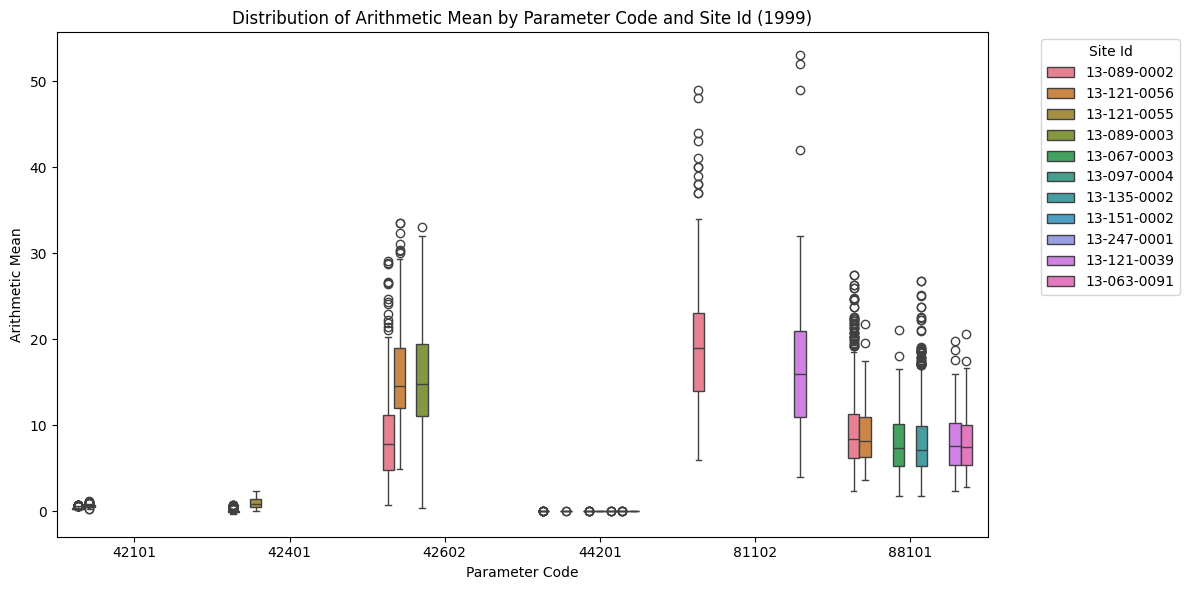

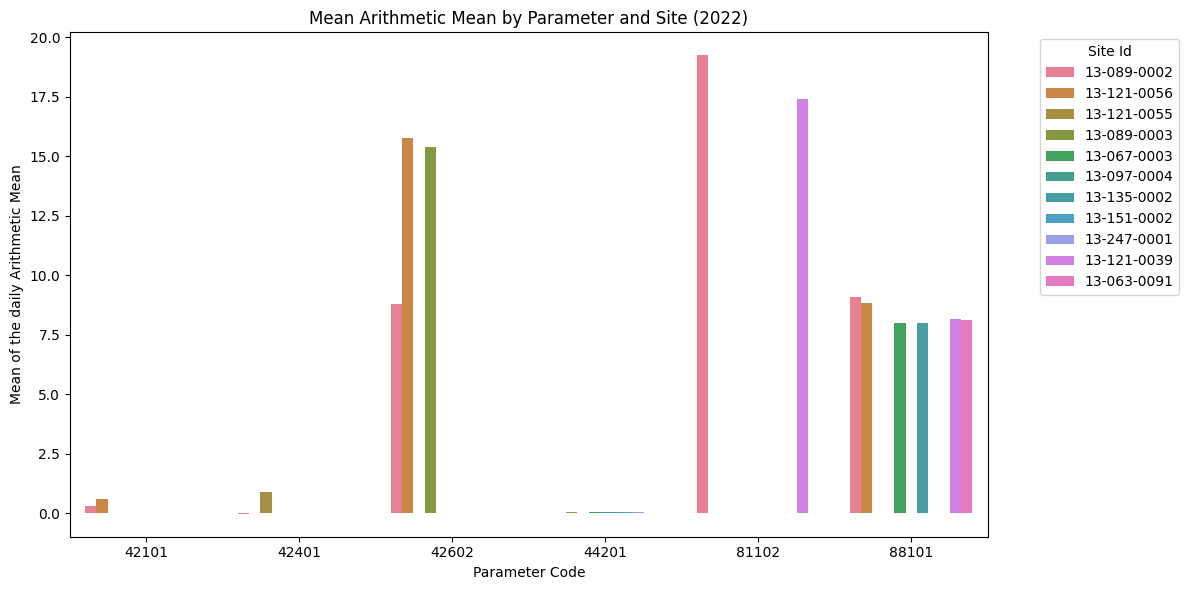

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#
urls = [
    "https://aqs.epa.gov/aqsweb/airdata/daily_44201_2022.zip",
    "https://aqs.epa.gov/aqsweb/airdata/daily_42401_2022.zip",
    "https://aqs.epa.gov/aqsweb/airdata/daily_42101_2022.zip",
    "https://aqs.epa.gov/aqsweb/airdata/daily_88101_2022.zip",
    "https://aqs.epa.gov/aqsweb/airdata/daily_81102_2022.zip",
    "https://aqs.epa.gov/aqsweb/airdata/daily_42602_2022.zip",
]

# List of the targeted sites
target_sites = all_site_ids_list + nearby_site_ids_lsit
print (target_sites)

all_data = []


for url in urls:

    df = pd.read_csv(url, compression='zip', low_memory=False)

    # Data cleaning and formatting, so that we can use the site-ids to select the targeted sites
    df['State Code'] = df['State Code'].astype(str).str.zfill(2)
    df['County Code'] = df['County Code'].astype(str).str.zfill(3)
    df['Site Num'] = df['Site Num'].astype(str).str.zfill(4)
    df['Site Id'] = df['State Code'] + '-' + df['County Code'] + '-' + df['Site Num']
    df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')
    print(f"Unique Site IDs for {url}: {df['Site Id'].unique()}")
    # Filter the data to get only the targeted sites
    df_target = df[df['Site Id'].isin(target_sites)]
    all_data.append(df_target)

# Merge all data
all_data_df = pd.concat(all_data, ignore_index=True)

# Compute the key statistics with daily arithmetic mean
stats_df = all_data_df.groupby(['Site Id', 'Parameter Code'])['Arithmetic Mean'].agg(
    ['mean', 'median', 'std', 'min', 'max']
).fillna(0).reset_index()

print("Key Statistics：")
print(stats_df)

# ======== Visulisation ========

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data_df, x='Parameter Code', y='Arithmetic Mean', hue='Site Id')
plt.title('Distribution of Arithmetic Mean by Parameter Code and Site Id (1999)')
plt.xlabel('Parameter Code')
plt.ylabel('Arithmetic Mean')
plt.legend(title='Site Id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Bar Chart
avg_df = stats_df[['Site Id', 'Parameter Code', 'mean']]
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_df, x='Parameter Code', y='mean', hue='Site Id')
plt.title('Mean Arithmetic Mean by Parameter and Site (2022)')
plt.xlabel('Parameter Code')
plt.ylabel('Mean of the daily Arithmetic Mean')
plt.legend(title='Site Id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
